# Import Packages

In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import utils
import pandas as pd
import numpy as np
import math
import random
from isoweek import Week
import lightgbm as lgb
import pickle
from sklearn.metrics import mean_squared_error

# Settings

In [2]:
forecast_horizon = 1
path_models = utils.get_project_root() + '/03_Forecasting_LightGBM/models/'
target_variable = 'Turnover' # Either 'Turnover' or 'Sales_QTY'

# Import Data

In [3]:
query = 'SELECT * FROM `globus-datahub-dev.Verteiler_PoC.timeseries_sales_weekly` where Year >= 2015 and (Year <= 2019 OR (Year = 2020 AND Week <= 47))  order by sku, site_id, year, week'
df_raw = utils.bq_to_dataframe(
    query, verbose=True).pipe(utils.reduce_memory_usage)

********************
Query Duration:  0:06:09.831257
Mem. usage decreased to 1449.68 Mb (13.8% reduction)


In [4]:
df = df_raw.copy()
df

,Week,Year,Date,Site_ID,SKU,Sales_QTY,Turnover,Season_Year,Vendor_ID,Vendor_Name,...,Warengruppe_ID,Warengruppe_Desc,Subclass_Desc,Class_Desc,Web_Article,Web_Article_From,Web_Article_To,CENSHARE_CAT_1,CENSHARE_CAT_2,CENSHARE_CAT_3
0,1,2015,2015W1,101,1014557,5.0,129.500000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
1,2,2015,2015W2,101,1014557,2.0,51.799999,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
2,3,2015,2015W3,101,1014557,0.0,0.000000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
3,4,2015,2015W4,101,1014557,1.0,25.900000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
4,5,2015,2015W5,101,1014557,0.0,0.000000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7876170,47,2020,2020W47,101,1289328500,4.0,56.090000,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
7876171,47,2020,2020W47,101,1289328600,2.0,29.799999,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
7876172,47,2020,2020W47,101,1289328700,5.0,32.869999,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
7876173,47,2020,2020W47,101,1289328800,4.0,27.600000,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe


# Preprocess Data

In [5]:
# Get rid of negative Sales / Turnover
df.loc[:, 'Sales_QTY'] = df.Sales_QTY.clip(lower=0)
df.loc[:, 'Turnover'] = df.Turnover.clip(lower=0)

# Replace Censhare Cat if not applicable
df.loc[df.CENSHARE_CAT_1.isna(), 'CENSHARE_CAT_1'] = 'NA'

# Aggregated Data

## Aggregation

In [6]:
df_aggregated = pd.pivot_table(df, values=target_variable, index=['Year','Week','Date','CENSHARE_CAT_1'], aggfunc=np.sum)
df_aggregated.reset_index(level=df_aggregated.index.names, inplace=True)

In [7]:
df_aggregated

,Year,Week,Date,CENSHARE_CAT_1,Turnover
0,2015,1,2015W1,Bad,11483.400391
1,2015,1,2015W1,Bett,35661.351562
2,2015,1,2015W1,Elektronik Gadget,636.500000
3,2015,1,2015W1,Heim & Haushalt,1992.900024
4,2015,1,2015W1,Kinder,124.700005
...,...,...,...,...,...
5006,2020,47,2020W47,Outdoor,3029.050049
5007,2020,47,2020W47,Papeterie,52536.050781
5008,2020,47,2020W47,Reisegepack,40673.160156
5009,2020,47,2020W47,Tisch,179621.281250


## Visualize Timeseries

In [8]:
def plot_timeseries(samples: int, sales: pd.core.frame.DataFrame) -> None:
    """
    Vizualize certain timeseries.
    :param: samples: list of Censhare 1 Categories - category to be vizualized.
            Example: ['Reisegepack', 'Papeterie','Kinder']
    :param: sales: DataFrame containing the sales data (columns SKU, Site_ID & Year_Week required)
    :return None
    """
    fig, axs = plt.subplots(math.ceil(n_series / 2), 2, figsize=(15, n_series * 1.5))
    axs = axs.flatten()
    ax_idx = 0

    for category in samples:
        df_article = sales.loc[sales.CENSHARE_CAT_1 == category].sort_values(by=['Year', 'Week']).reset_index()

        df_article.plot(x='Date',
                     y=target_variable,
                     title= f'CENSHARE_CAT_1: {category}',
                     ax=axs[ax_idx])
        ax_idx += 1

    plt.tight_layout()
    plt.show()

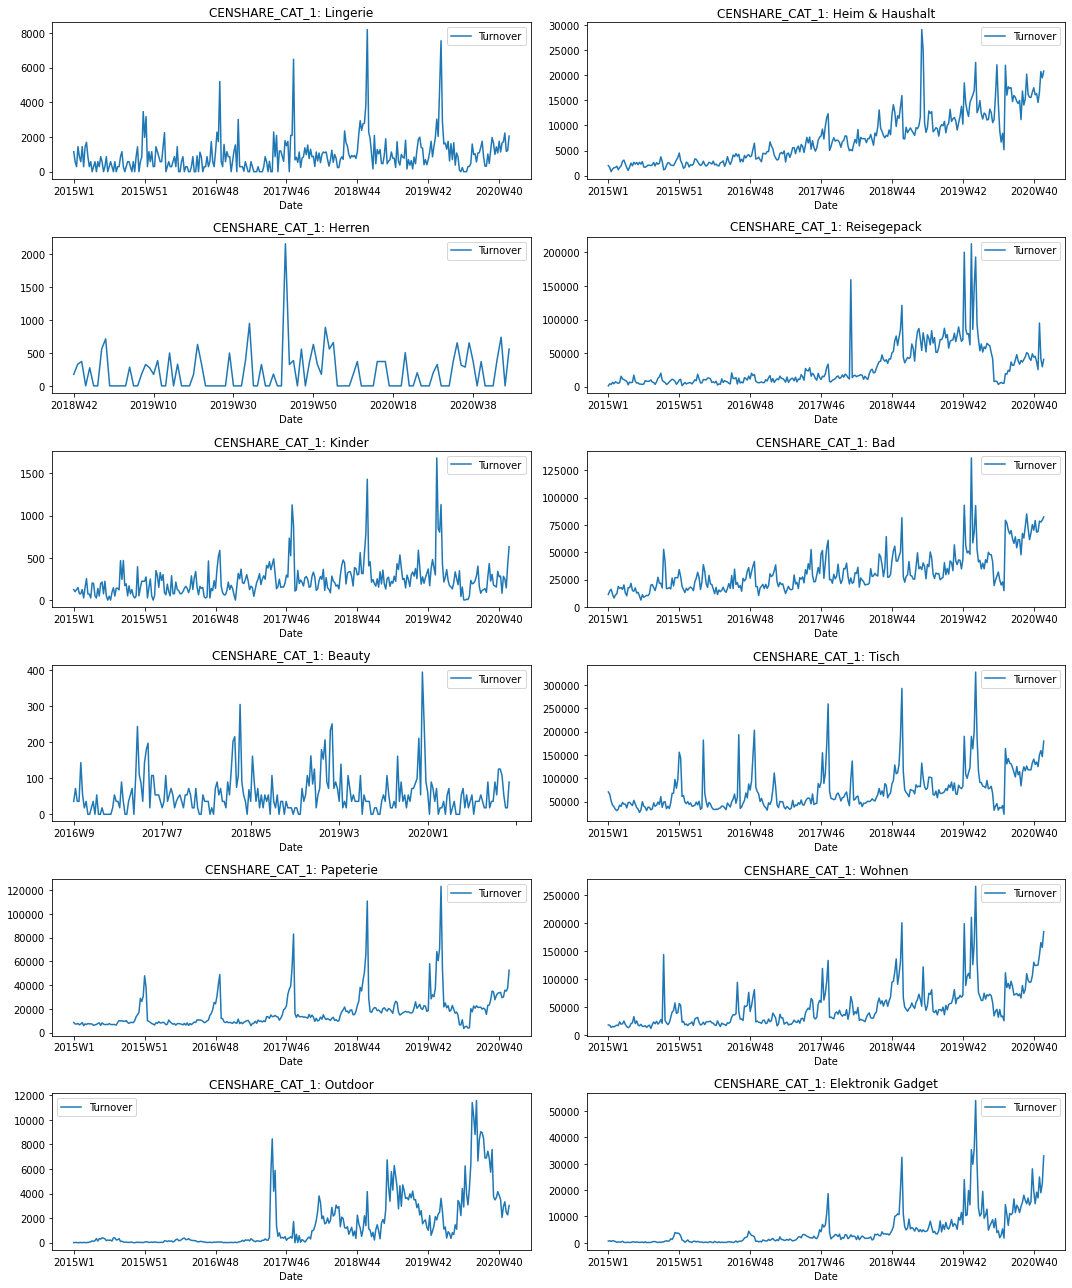

In [9]:
n_series = 12

samples = df_aggregated['CENSHARE_CAT_1'].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()

plot_timeseries(samples, df_aggregated)

## Feature Engineering

In [10]:
df_aggregated['rolling_mean_w4'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(1).rolling(window=4,min_periods=0).mean()).fillna(0)

df_aggregated['rolling_mean_w8'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(1).rolling(window=8,min_periods=0).mean()).fillna(0)

df_aggregated['lag_w1'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(1))

df_aggregated['lag_w2'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(2))

df_aggregated['lag_w3'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(3))

df_aggregated['lag_w4'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(4))

df_aggregated['lag_y1'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(52))

df_aggregated['lag_y2'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(104))

In [11]:
df_aggregated

,Year,Week,Date,CENSHARE_CAT_1,Turnover,rolling_mean_w4,rolling_mean_w8,lag_w1,lag_w2,lag_w3,lag_w4,lag_y1,lag_y2
0,2015,1,2015W1,Bad,11483.400391,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,2015W1,Bett,35661.351562,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,2015W1,Elektronik Gadget,636.500000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,2015W1,Heim & Haushalt,1992.900024,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,2015W1,Kinder,124.700005,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5006,2020,47,2020W47,Outdoor,3029.050049,2748.135010,3069.942383,2263.510010,2469.129883,3328.000000,2931.899902,2125.369873,511.399994
5007,2020,47,2020W47,Papeterie,52536.050781,34578.007812,33536.304688,37621.128906,34925.140625,35719.570312,30046.199219,37343.820312,35071.332031
5008,2020,47,2020W47,Reisegepack,40673.160156,47921.410156,45828.710938,29619.220703,41831.410156,94829.812500,25405.199219,62278.378906,75405.664062
5009,2020,47,2020W47,Tisch,179621.281250,145115.156250,139839.593750,146222.578125,159310.437500,149923.234375,125004.398438,122274.570312,109555.773438


## Forecast (LightGBM)

In [12]:
cat_features = [
'Week', 'Year', 'CENSHARE_CAT_1']

num_features = [
'rolling_mean_w4',
       'rolling_mean_w8', 'lag_w1', 'lag_w2', 'lag_w3', 'lag_w4', 'lag_y1',
       'lag_y2'
]

features = cat_features + num_features

In [13]:
# Convert categorical features to integers 
df_aggregated, encoders_dict = utils.encode_categorical(df_aggregated, cat_features, return_encoders = True)

In [14]:
df_aggregated

,Year,Week,Date,CENSHARE_CAT_1,Turnover,rolling_mean_w4,rolling_mean_w8,lag_w1,lag_w2,lag_w3,lag_w4,lag_y1,lag_y2
0,0,0,2015W1,0,11483.400391,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,2015W1,2,35661.351562,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2015W1,4,636.500000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2015W1,6,1992.900024,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,2015W1,8,124.700005,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5006,5,46,2020W47,13,3029.050049,2748.135010,3069.942383,2263.510010,2469.129883,3328.000000,2931.899902,2125.369873,511.399994
5007,5,46,2020W47,14,52536.050781,34578.007812,33536.304688,37621.128906,34925.140625,35719.570312,30046.199219,37343.820312,35071.332031
5008,5,46,2020W47,15,40673.160156,47921.410156,45828.710938,29619.220703,41831.410156,94829.812500,25405.199219,62278.378906,75405.664062
5009,5,46,2020W47,16,179621.281250,145115.156250,139839.593750,146222.578125,159310.437500,149923.234375,125004.398438,122274.570312,109555.773438


In [15]:
splits = utils.get_splits(df_aggregated, fh=forecast_horizon, n_splits=1)

In [16]:
model_params = {
    'seed': 10,
    'objective': 'poisson',
    'metric': 'rmse',
    'num_leaves': 2^4,
    'max_bin': 1000,
    }

In [17]:
rmse = []

for week, year in splits:
    print(f'\n\n****** {year}W{week} ******')
    
    evals_result = {}
    
    week=int(week)
    year=int(year)
    
    # Train data: same year and past week OR past year
    x_train = df_aggregated.loc[((df_aggregated.Year == (Week(year, week))[0]) & (df_aggregated.Week <= (Week(year, week))[1])) | (df_aggregated.Year < (Week(year, week))[0])][features]
    y_train = df_aggregated.loc[((df_aggregated.Year == (Week(year, week))[0]) & (df_aggregated.Week <= (Week(year, week))[1])) | (df_aggregated.Year < (Week(year, week))[0])][target_variable]

    x_test = df_aggregated.loc[df_aggregated.Year == (Week(year, week)+1)[0]].loc[df_aggregated.Week == (Week(year, week)+1)[1]][features]
    y_test = df_aggregated.loc[df_aggregated.Year == (Week(year, week)+1)[0]].loc[df_aggregated.Week == (Week(year, week)+1)[1]][target_variable]
    
    
    
    train_data = lgb.Dataset(x_train, label=y_train,
                             categorical_feature=cat_features, free_raw_data=False,
                           )
    validation_data = lgb.Dataset(
        x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
    )
    
    
    
    gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                    evals_result=evals_result, num_boost_round=1000,
                    verbose_eval=25, early_stopping_rounds=20,
                   )

    
    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
    
    gbm.save_model(path_models + f'gbm_{year}w{week}.txt', num_iteration=gbm.best_iteration) 
    
    evals_result_p = open(path_models+ f'evals_result_{year}w{week}.pkl', 'wb')
    pickle.dump(evals_result, evals_result_p)
    evals_result_p.close()
    
    rmse.append(mean_squared_error(y_test, y_pred, squared=False))




****** 5W45 ******
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8078
[LightGBM] [Info] Number of data points in the train set: 4993, number of used features: 11
[LightGBM] [Info] Start training from score 10.070731
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 17108	valid_1's rmse: 42580.2
[50]	training's rmse: 12959.6	valid_1's rmse: 28503.8
[75]	training's rmse: 11845.7	valid_1's rmse: 22604.1
[100]	training's rmse: 11232.9	valid_1's rmse: 20926.2
[125]	training's rmse: 10690	valid_1's rmse: 20011.7
[150]	training's rmse: 10383.3	valid_1's rmse: 19727
Early stopping, best iteration is:
[144]	training's rmse: 10467.6	valid_1's rmse: 19527.6


c:\dev\verteiler\venv5\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv5\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv5\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


In [18]:
print('RMSE:\n', rmse)
    
print('\nCrossvalidated RMSE: ', np.mean(rmse))

RMSE:
 [19527.59237938346]

Crossvalidated RMSE:  19527.59237938346


****** 5W45 ******


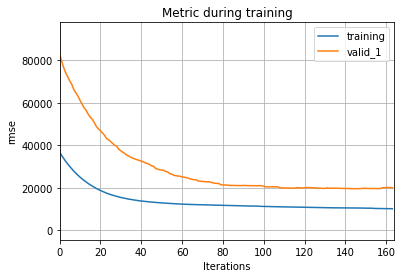

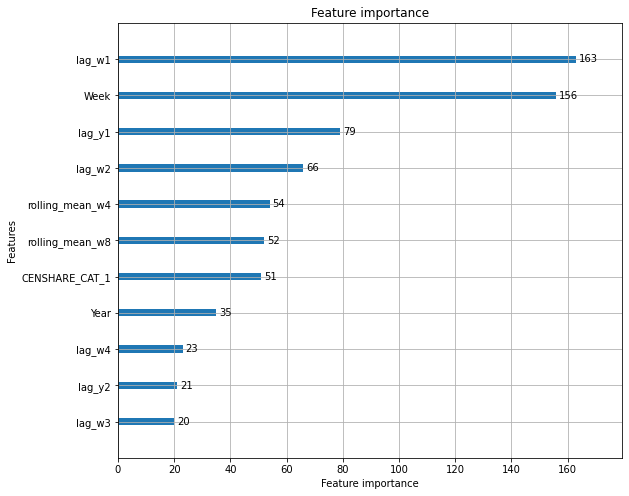

In [19]:
for week, year in splits:
    print(f'****** {year}W{week} ******')
    
    mod = lgb.Booster(model_file=path_models + f'gbm_{year}w{week}.txt')
    evals = pickle.load(open(path_models + f'evals_result_{year}w{week}.pkl', 'rb'))

    ax = lgb.plot_metric(evals)
    plt.show()
    
    ax = lgb.plot_importance(mod, figsize=(10,8))
    plt.gcf().subplots_adjust(left=0.2)
    plt.show()
    

In [20]:
# Gather results of this article category and store them in general result_df
results_df = x_test[['Week', 'Year', 'CENSHARE_CAT_1']].copy()
results_df = utils.decode_categorical(results_df, encoders_dict)
results_df[target_variable] = list(y_test)
results_df['Prediction'] = list(y_pred)
results_df

,Week,Year,CENSHARE_CAT_1,Turnover,Prediction
4993,47,2020,Bad,82315.570312,80141.728878
4994,47,2020,Beauty,89.500000,161.694885
4995,47,2020,Bett,109553.679688,109625.767622
4996,47,2020,Damen Accessoires,18353.869141,17956.145565
4997,47,2020,Elektronik Gadget,32968.609375,23260.774361
4998,47,2020,Gewurze,24.900000,140.253651
4999,47,2020,Heim & Haushalt,20785.519531,20099.510625
5000,47,2020,Herren,560.000000,247.907426
5001,47,2020,Kinder,632.859985,384.793643
5002,47,2020,Kuche,293712.656250,232958.859201


In [21]:
mean_squared_error(results_df.Turnover, results_df.Prediction, squared=False)

19527.59237938346

## Forecast (Naive)

In [22]:
forecasts_naive = list(df_aggregated.loc[df_aggregated.Year == (Week(year, week))[0]].loc[df_aggregated.Week == (Week(year, week))[1]][target_variable])

In [23]:
mean_squared_error(results_df.Turnover, forecasts_naive, squared=False)

19720.169678533817

Forecasts with LightGBM are more accurate then forecasts computed with the naive approach

# Compute Bottom Level Forecasts

In [24]:
df['rolling_mean_w4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1).rolling(window=4).mean())

df['rolling_mean_w8'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1).rolling(window=8).mean())

df['lag_w1'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1))

df['lag_w2'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(2))

df['lag_w3'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(3))

df['lag_w4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(4))

df['lag_y1'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(52))

df['lag_y2'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(104))


In [25]:
cat_features = [
'Week', 'Year', 'Site_ID', 'SKU','Season_Year',
       'Vendor_ID', 'Price_Level', 'Web_Article', 'CENSHARE_CAT_1',
       'CENSHARE_CAT_2', 'CENSHARE_CAT_3'
]

num_features = [
'rolling_mean_w4', 'lag_w1',
       'lag_w2', 'lag_w3', 'lag_w4', 'lag_y1', 'lag_y2'
]

features = cat_features + num_features

In [26]:
# Convert categorical features to integers 
df, encoders_dict = utils.encode_categorical(df, cat_features, return_encoders = True)

In [27]:
splits = utils.get_splits(df, fh=forecast_horizon, n_splits=1)

In [28]:
model_params = {
    'seed': 10,
    'objective': 'poisson',
    'metric': 'rmse',
    'num_leaves': 2^4,
    'max_bin': 1000,
    }

In [29]:
rmse = []

for week, year in splits:
    print(f'\n\n****** {year}W{week} ******')
    
    evals_result = {}
    
    week=int(week)
    year=int(year)
    
    # Train data: same year and past week OR past year
    x_train = df.loc[((df.Year == (Week(year, week))[0]) & (df.Week <= (Week(year, week))[1])) | (df.Year < (Week(year, week))[0])][features]
    y_train = df.loc[((df.Year == (Week(year, week))[0]) & (df.Week <= (Week(year, week))[1])) | (df.Year < (Week(year, week))[0])][target_variable]

    x_test = df.loc[df.Year == (Week(year, week)+1)[0]].loc[df.Week == (Week(year, week)+1)[1]][features]
    y_test = df.loc[df.Year == (Week(year, week)+1)[0]].loc[df.Week == (Week(year, week)+1)[1]][target_variable]
    
    
    
    train_data = lgb.Dataset(x_train, label=y_train,
                             categorical_feature=cat_features, free_raw_data=False,
                           )
    validation_data = lgb.Dataset(
        x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
    )
    
    
    
    gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                    evals_result=evals_result, num_boost_round=1000,
                    verbose_eval=25, early_stopping_rounds=20,
                   )

    
    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
    
    gbm.save_model(path_models + f'gbm_{year}w{week}.txt', num_iteration=gbm.best_iteration) 
    
    evals_result_p = open(path_models+ f'evals_result_{year}w{week}.pkl', 'wb')
    pickle.dump(evals_result, evals_result_p)
    evals_result_p.close()
    
    rmse.append(mean_squared_error(y_test, y_pred, squared=False))




****** 5W45 ******


c:\dev\verteiler\venv5\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.183368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14681
[LightGBM] [Info] Number of data points in the train set: 7816222, number of used features: 18
[LightGBM] [Info] Start training from score 2.714812
Training until validation scores don't improve for 20 rounds


c:\dev\verteiler\venv5\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv5\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[25]	training's rmse: 88.0525	valid_1's rmse: 120.554
[50]	training's rmse: 87.1513	valid_1's rmse: 119.882
[75]	training's rmse: 86.5733	valid_1's rmse: 119.44
[100]	training's rmse: 86.0898	valid_1's rmse: 119.279
[125]	training's rmse: 85.6453	valid_1's rmse: 118.95
[150]	training's rmse: 85.1168	valid_1's rmse: 118.68
[175]	training's rmse: 84.1995	valid_1's rmse: 118.539
[200]	training's rmse: 83.6932	valid_1's rmse: 118.346
[225]	training's rmse: 82.9737	valid_1's rmse: 118.173
[250]	training's rmse: 82.1264	valid_1's rmse: 118.09
[275]	training's rmse: 81.6126	valid_1's rmse: 117.991
[300]	training's rmse: 81.3918	valid_1's rmse: 117.96
[325]	training's rmse: 80.6059	valid_1's rmse: 117.92
[350]	training's rmse: 80.5641	valid_1's rmse: 117.903
[375]	training's rmse: 80.3571	valid_1's rmse: 117.926
Early stopping, best iteration is:
[362]	training's rmse: 80.4786	valid_1's rmse: 117.873


****** 5W45 ******


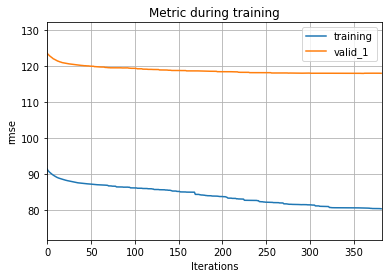

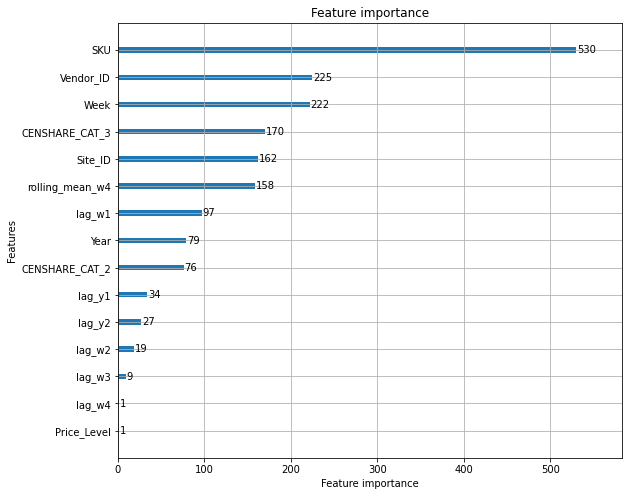

In [30]:
for week, year in splits:
    print(f'****** {year}W{week} ******')
    
    mod = lgb.Booster(model_file=path_models + f'gbm_{year}w{week}.txt')
    evals = pickle.load(open(path_models + f'evals_result_{year}w{week}.pkl', 'rb'))

    ax = lgb.plot_metric(evals)
    plt.show()
    
    ax = lgb.plot_importance(mod, figsize=(10,8))
    plt.gcf().subplots_adjust(left=0.2)
    plt.show()
    

In [32]:
results_bottom_level = x_test[['Week', 'Year', 'Site_ID','SKU','CENSHARE_CAT_1']].copy()
results_bottom_level = utils.decode_categorical(results_bottom_level, encoders_dict)
results_bottom_level[target_variable] = list(y_test)
results_bottom_level['Prediction'] = list(y_pred)
results_bottom_level

,Week,Year,Site_ID,SKU,CENSHARE_CAT_1,Turnover,Prediction
307,47,2020,101,1014557,Kuche,29.900000,31.680104
615,47,2020,102,1014557,Kuche,0.000000,9.779931
923,47,2020,103,1014557,Kuche,0.000000,10.905811
1231,47,2020,106,1014557,Kuche,0.000000,11.735825
1539,47,2020,107,1014557,Kuche,0.000000,14.715816
...,...,...,...,...,...,...,...
7876170,47,2020,101,1289328500,Ordnung & Aufbewahrung,56.090000,98.942157
7876171,47,2020,101,1289328600,Ordnung & Aufbewahrung,29.799999,98.942157
7876172,47,2020,101,1289328700,Ordnung & Aufbewahrung,32.869999,98.942157
7876173,47,2020,101,1289328800,Ordnung & Aufbewahrung,27.600000,98.942157


## Correct bottom level Forecasts based on aggregated ones

In [33]:
for cat in results_bottom_level.CENSHARE_CAT_1.drop_duplicates():
    factor = results_bottom_level.loc[results_bottom_level.CENSHARE_CAT_1 == cat].Prediction.sum()  / float(results_df.loc[results_df.CENSHARE_CAT_1 == cat].Prediction)
    results_bottom_level.loc[results_bottom_level.CENSHARE_CAT_1 == cat,'Prediction_v2'] = results_bottom_level.Prediction / factor


# Validate Forecasts

In [34]:
mean_squared_error(results_bottom_level.Prediction_v2, results_bottom_level.Turnover, squared=False)

117.82371052826481